<a href="https://colab.research.google.com/github/lucasresck/FGV-EMAp/blob/master/Modeling%20Biological%20Phenomena/A1%20assignment/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulação computacional de processos evolutivos e seleção natural

Foi implementado um ambiente com comida limitada e vários indivíduos de certa espécie, que devem competir entre si.
A cada dia, a comida é distribuída, uma a uma, a cada indivíduo.
Cada indivíduo tem um grau de adaptação (*fitness*), que é indicativo da probabilidade de receber a comida. Se receber uma comida, ele sobrevive para o dia seguinte; se receber duas comidas, ele sobrevive para o dia seguinte e se reproduz, saindo automaticamente do sorteio das próximas comidas no mesmo dia.
Cada indivíduo também tem energia, que indica em quantas rodadas de distribuição no mesmo dia um indivíduo pode participar. Se o indivíduo fica sem energia durante a distribuição neste dia, ele automaticamente morre.
O grau de adaptação dos indivíduos, neste caso, é sua característica de velocidade. Ou seja, quanto mais veloz, mais adaptado. Porém, a velocidade tem custo na energia, sendo que a cada rodada de distribuição é descontada da energia do indivíduo o quadrado da velocidade.
Quando um indivíduo se reproduz, existe uma probabilidade pequena de que haja uma mutação na característica de velocidade do seu descendente.
O objetivo, portanto, dessa implementação, é verificar como os indivíduos se comportam em um ambiente com comida escassa e como encontram a velocidade que maximiza a probabilidade de sobreviverem (ou seja, maximiza junto energia e grau de adaptação).

In [0]:
import random
import time
import matplotlib.pyplot as plt
import statistics
import numpy as np

random.seed(time.time())

class Environment:
    def __init__(self, n, speed, energy, mutation):
        self.n = n
        self.speed = speed
        self.energy = energy
        self.mutation = mutation
        self.getIndividuals()
        self.dataMean = []
        self.dataVariance = []
        self.dataN = []
        self.born = n
        self.died = 0

    def getIndividuals(self):  # Create individuals
        self.individuals = [Individual(speed = self.speed, energy = self.energy) for i in range(self.n)]

    def run(self, days, nFood):
        self.record()
        self.days = days
        self.nFood = nFood

        for day in range(days):
            individualsThisDay = self.individuals.copy()
            for epoch in range(self.nFood):
                for individual in individualsThisDay.copy():
                    if individual.energy < (individual.speed)**2 or individual.food == 2:
                        individualsThisDay.remove(individual)
                    else:
                        individual.energy -= (individual.speed)**2
                self.sortFood(individualsThisDay)
            
            for individual in self.individuals.copy():
                if individual.food == 0:
                    #count += 1
                    self.individuals.remove(individual)
                    self.died +=1
                    continue
                elif individual.food == 2:
                    self.reprodution(individual)
                    self.born += 1
                individual.energy = self.energy
                individual.food = 0

            self.record()
            
    def sortFood(self, individualsThisDay):
        sumFitness = 0
        for individual in individualsThisDay:
            sumFitness += individual.fitness
        lucky = random.random()*sumFitness
        for i, individual in enumerate(individualsThisDay):
            if lucky < individual.fitness:
                individual.food += 1
                break
            else:
                lucky -= individual.fitness

    def reprodution(self, individual):
        dice = random.random()
        newSpeed = individual.speed
        if dice < self.mutation:
            newSpeed += random.random()*2 - 1
        self.individuals.append(Individual(speed = newSpeed, energy = self.energy))

    def record(self):
        self.dataMean.append(sum([individual.fitness for individual in self.individuals])/len(self.individuals))
        self.dataVariance.append(statistics.variance([individual.fitness for individual in self.individuals]))
        self.dataN.append(len(self.individuals))

    def plot(self):
        print("During " + str(self.days) + " days:")
        print()
        print(str(self.born) + " individuals were born")
        print(str(self.died) + " individuals died")
        print("Mean of fitness: " + str(self.dataMean[-1]))

        t = np.arange(0, self.days + 1)
        
        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataMean)
        ax.set_xlabel("Time")
        ax.set_ylabel("Mean of fitness")
        plt.show()

        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataVariance)
        ax.set_ylabel("Variance of fitness")
        ax.set_xlabel("Time")
        plt.show()

        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel("Number of individuals")
        ax.plot(t, self.dataN)
        ax.set_xlabel("Time")
        plt.show()

class Individual:
    def __init__(self, speed, energy):
        self.speed = speed
        self.energy = energy
        self.fitness = speed  # Fitness is the degree of adaptation
        self.food = 0

During 500 days:

15769 individuals were born
15669 individuals died
Mean of fitness: 1.2026010828926845


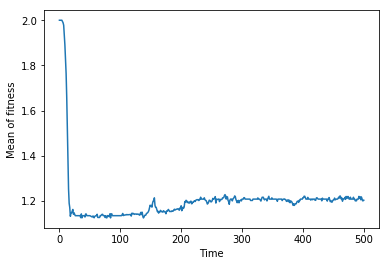

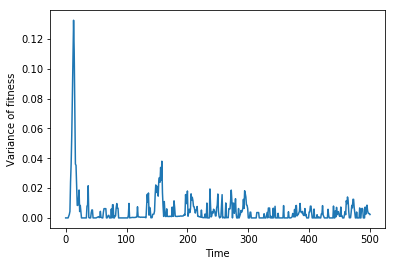

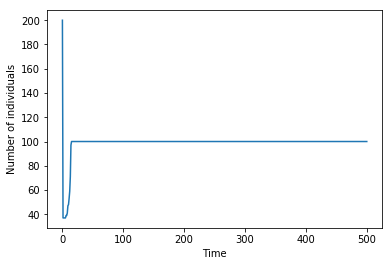

In [112]:
env = Environment(n = 200, speed = 2, energy = 150, mutation = 0.01)
env.run(days = 500, nFood = 100)
env.plot()

During 500 days:

15890 individuals were born
15790 individuals died
Mean of fitness: 1.1883665782247883


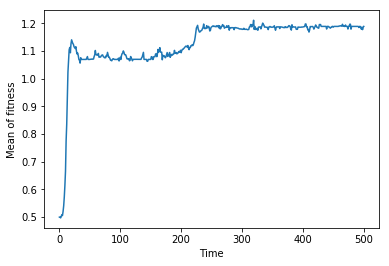

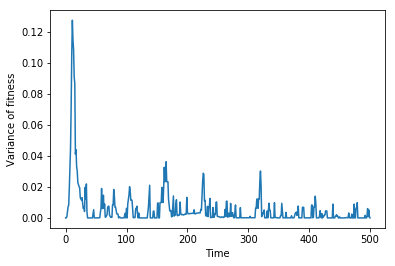

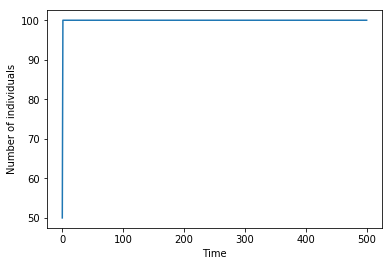

In [113]:
env = Environment(n = 50, speed = 0.5, energy = 150, mutation = 0.01)
env.run(days = 500, nFood = 100)
env.plot()

Observamos que, em ambos os casos em que os indivíduos são iniciados com velocidade alta e velocidade baixa, existe uma convergência da velocidade média dos indivíduos para algo em torno de 1,2. Além disso, o número de indivíduos sempre se iguala a 100.
No caso do número de indivíduos, isso é de certa forma óbvio: não há comida para todos, há apenas para 100 indíviduos, no máximo. E, caso algum indíviduo receba duas comidas, ele se reproduz, então a quantidade de indíviduos se mantém em 100.
Aparentemente a velocidade média (que procura sempre aumentar, pois aumenta o grau de adaptação) sobe até que comece a haver prejuízo para o indivíduo, ou seja, ele não tenha energia para todas as rodadas. Observe que 1,2, mais ou menos, é o valor ideal de velocidade que não prejudica a energia, pois 150/(1.2²) indica quantas rodadas o indivíduo participa, algo que fica próximo de 100.

Podemos melhorar nosso modelo, adicionando mais características (peso e tamanho) e permitindo que os indivíduos morram por idade.

In [0]:
class Environment2:
    def __init__(self, n, speed, size, weight, energy, mutation, age):
        self.n = n
        self.speed = speed
        self.energy = energy
        self.mutation = mutation
        self.size = size
        self.weight = weight
        self.age = age
        self.getIndividuals()
        self.dataMean = []
        self.dataVariance = []
        self.dataMeanSpeed = []
        self.dataVarianceSpeed = []
        self.dataMeanSize = []
        self.dataVarianceSize = []
        self.dataMeanWeight = []
        self.dataVarianceWeight = []
        self.dataN = []
        self.born = n
        self.died = 0
        self.diedAge = 0

    def getIndividuals(self):  # Create individuals
        self.individuals = [Individual2(speed = self.speed, size = self.size,
                                        weight = self.weight,
                                        energy = self.energy) for i in range(self.n)]

    def run(self, days, nFood):
        self.record()
        self.days = days
        self.nFood = nFood

        for day in range(days):
            individualsThisDay = self.individuals.copy()
            for epoch in range(self.nFood):  #Who entered here is guaranteed that has energy and is not full of food
                for individual in individualsThisDay.copy():
                    if (individual.energy < individual.speed**2 + individual.size**3 + individual.weight
                    or individual.food == 2):
                        individualsThisDay.remove(individual)
                    else:
                        individual.energy -= individual.speed**2 + individual.size**3 + individual.weight
                self.sortFood(individualsThisDay)

            for individual in self.individuals.copy():
                if individual.food == 0:
                    #count += 1
                    self.individuals.remove(individual)
                    self.died += 1
                    continue
                elif individual.food == 2:
                    self.reprodution(individual)
                    self.born += 1
                individual.food = 0
                individual.energy = self.energy
                individual.age += 1
                if individual.age >= self.age:
                    self.individuals.remove(individual)
                    self.died += 1
                    self.diedAge += 1

            self.record()
            
    def sortFood(self, individualsThisDay):
        sumFitness = 0
        for individual in individualsThisDay:
            sumFitness += individual.fitness
        lucky = random.random()*sumFitness
        for i, individual in enumerate(individualsThisDay):
            if lucky < individual.fitness:
                individual.food += 1
                break
            else:
                lucky -= individual.fitness

    def reprodution(self, individual):
        dice = random.random()
        newSpeed = individual.speed
        if dice < self.mutation:
            newSpeed += random.random()*2 - 1

        dice = random.random()
        newSize = individual.size
        if dice < self.mutation:
            newSize += random.random()*2 - 1

        dice = random.random()
        newWeight = individual.weight
        if dice < self.mutation:
            newWeight += random.random()*2 - 1

        self.individuals.append(Individual2(speed = newSpeed, size = newSize,
                                            weight = newWeight, energy = self.energy))

    def record(self):
        self.dataMean.append(sum([individual.fitness for individual in self.individuals])/len(self.individuals))
        self.dataVariance.append(statistics.variance([individual.fitness for individual in self.individuals]))
        self.dataMeanSpeed.append(sum([individual.speed for individual in self.individuals])/len(self.individuals))
        self.dataVarianceSpeed.append(statistics.variance([individual.speed for individual in self.individuals]))
        self.dataMeanSize.append(sum([individual.size for individual in self.individuals])/len(self.individuals))
        self.dataVarianceSize.append(statistics.variance([individual.size for individual in self.individuals]))
        self.dataMeanWeight.append(sum([individual.weight for individual in self.individuals])/len(self.individuals))
        self.dataVarianceWeight.append(statistics.variance([individual.weight for individual in self.individuals]))
        self.dataN.append(len(self.individuals))
        #print(self.data[-1])

    def plot(self):
        print("During " + str(self.days) + " days:")
        print()
        print(str(self.born) + " individuals were born")
        print(str(self.died) + " individuals died, " + str(self.diedAge) + " of them by age")
        print("Mean of fitness: " + str(self.dataMean[-1]))
        print("Mean of speed: " + str(self.dataMeanSpeed[-1]))
        print("Mean of size: " + str(self.dataMeanSize[-1]))
        print("Mean of weight: " + str(self.dataMeanWeight[-1]))

        t = np.arange(0, self.days + 1)

        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataMean, label = "fitness")
        ax.plot(t, self.dataMeanSpeed, label = "speed")
        ax.plot(t, self.dataMeanSize, label = "size")
        ax.plot(t, self.dataMeanWeight, label = "weight")
        ax.set_xlabel("Time")
        ax.set_ylabel("Mean of")
        ax.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataVariance, label = "fitness")
        ax.plot(t, self.dataVarianceSpeed, label = "speed")
        ax.plot(t, self.dataVarianceSize, label = "size")
        ax.plot(t, self.dataVarianceWeight, label = "weight")
        ax.set_ylabel("Variance of fitness")
        ax.set_xlabel("Time")
        ax.legend()
        plt.show()
        
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel("Number of individuals")
        ax.plot(t, self.dataN)
        ax.set_xlabel("Time")
        plt.show()

class Individual2:
    def __init__(self, speed, size, weight, energy):
        self.speed = speed
        self.size = size
        self.weight = weight
        self.energy = energy
        self.fitness = speed + size + weight  # Fitness is the degree of adaptation
        self.food = 0
        self.age = 0

During 1000 days:

31816 individuals were born
31718 individuals died, 745 of them by age
Mean of fitness: 1.912992613582613
Mean of speed: 0.8785270324496924
Mean of size: 0.4948475240055755
Mean of weight: 0.5396180571273443


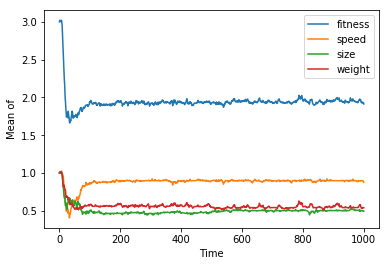

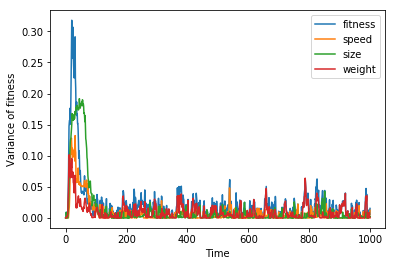

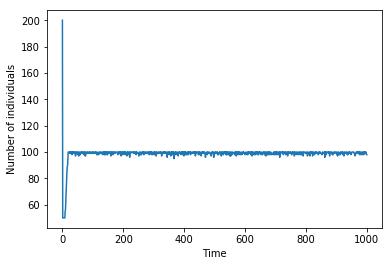

In [115]:
env3 = Environment2(n = 200, speed = 1, size = 1, weight = 1, energy = 150, mutation = 0.01, age = 10)
env3.run(days = 1000, nFood = 100)
env3.plot()

During 1000 days:

31912 individuals were born
31812 individuals died, 725 of them by age
Mean of fitness: 1.9676498325183087
Mean of speed: 0.13256110603626564
Mean of size: 0.43834169854333266
Mean of weight: 1.3967470279387129


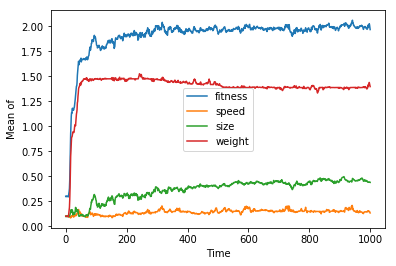

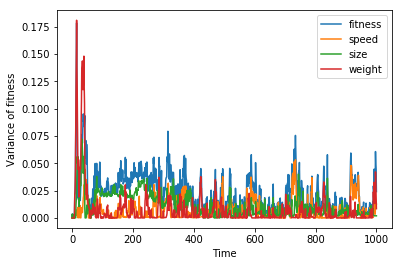

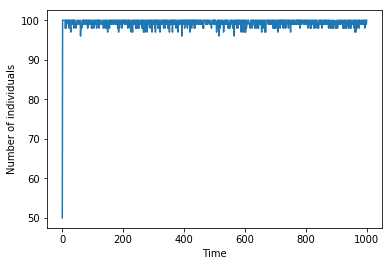

In [116]:
env4 = Environment2(n = 50, speed = 0.1, size = 0.1, weight = 0.1,
                    energy = 150, mutation = 0.01, age = 10)
env4.run(days = 1000, nFood = 100)
env4.plot()

Neste caso, a análise é similar à do ambiente anterior.
A população tende a ficar estável em 100 indivíduos, pela quantidade de comida disponível e pelos nascimentos. As mortem afetam muito pouco, pois, se alguém morre, sobra comida, eventualmente ajudando algum indivíduo a se reproduzir.
Tanto no caso em que as características estão abaixo da ideal quanto naqueles casos em que eças estão acima, há uma tendência de estabilização do grau de adaptação em torno de 2.0.

Vamos adicionar reprodução sexuada ao modelo. Indivíduos agora têm sexo e se reproduzem entre si, ao invés se de replicarem. Os indíviduos que obtiverem duas comidas em um dia são aqueles com a capacidade de reprodução naquele dia. Entre os indivíduos capazes de se reproduzir, os mais bem adaptados de um sexo se reproduzem com os mais bem adaptados do outro. Como o número de indivíduos com capacidade de reprodução em um determinado dia é diferente entre os sexos, alguns indivíduos não conseguirão se reproduzir.

In [0]:
class Environment3:
    def __init__(self, n, speed, size, weight, energy, mutation, age):
        self.n = n
        self.speed = speed
        self.energy = energy
        self.mutation = mutation
        self.size = size
        self.weight = weight
        self.age = age
        self.getIndividuals()
        self.dataMean = []
        self.dataVariance = []
        self.dataMeanSpeed = []
        self.dataVarianceSpeed = []
        self.dataMeanSize = []
        self.dataVarianceSize = []
        self.dataMeanWeight = []
        self.dataVarianceWeight = []
        self.dataN = []
        self.born = n
        self.died = 0
        self.diedAge = 0

    def getIndividuals(self):  # Create individuals
        self.individuals = [Individual3(speed = self.speed, size = self.size,
                                        weight = self.weight,
                                        energy = self.energy) for i in range(self.n)]

    def run(self, days, nFood):
        self.record()
        self.days = days
        self.nFood = nFood

        for day in range(days):
            individualsThisDay = self.individuals.copy()
            for epoch in range(self.nFood):  #Who entered here is guaranteed that has energy and is not full of food
                for individual in individualsThisDay.copy():
                    if (individual.energy < individual.speed**2 + individual.size**3 + individual.weight
                    or individual.food == 2):
                        individualsThisDay.remove(individual)
                    else:
                        individual.energy -= individual.speed**2 + individual.size**3 + individual.weight
                self.sortFood(individualsThisDay)

            toReproduce = []
            for individual in self.individuals.copy():
                if individual.food == 0:
                    #count += 1
                    self.individuals.remove(individual)
                    self.died += 1
                    continue
                elif individual.food == 2:
                    #self.reprodution(individual)
                    toReproduce.append(individual)
                individual.food = 0
                individual.energy = self.energy
                individual.age += 1
                if individual.age >= self.age:
                    self.individuals.remove(individual)
                    self.died += 1
                    self.diedAge += 1

            self.reproduce(toReproduce)
            self.record()
            
    def sortFood(self, individualsThisDay):
        sumFitness = 0
        for individual in individualsThisDay:
            sumFitness += individual.fitness
        lucky = random.random()*sumFitness
        for i, individual in enumerate(individualsThisDay):
            if lucky < individual.fitness:
                individual.food += 1
                break
            else:
                lucky -= individual.fitness

    def reproduce(self, toReproduce):
        females = [individual for individual in toReproduce if individual.sex == 1]
        females = sorted(females, key=lambda individual: individual.fitness, reverse=True)
        males = [individual for individual in toReproduce if individual.sex == 0]
        males = sorted(males, key=lambda individual: individual.fitness, reverse=True)

        n = min(len(females), len(males))

        for couple in range(n):

            newSpeed = (females[couple].speed + males[couple].speed)/2
            dice = random.random()
            if dice < self.mutation:
                newSpeed += random.random()*2 - 1

            newSize = (females[couple].size + males[couple].size)/2
            dice = random.random()
            if dice < self.mutation:
                newSize += random.random()*2 - 1

            newWeight = (females[couple].weight + males[couple].weight)/2
            dice = random.random()
            if dice < self.mutation:
                newWeight += random.random()*2 - 1

            self.individuals.append(Individual3(speed = newSpeed, size = newSize,
                                                weight = newWeight, energy = self.energy))
            self.born += 1

    def record(self):
        self.dataMean.append(sum([individual.fitness for individual in self.individuals])/len(self.individuals))
        self.dataVariance.append(statistics.variance([individual.fitness for individual in self.individuals]))
        self.dataMeanSpeed.append(sum([individual.speed for individual in self.individuals])/len(self.individuals))
        self.dataVarianceSpeed.append(statistics.variance([individual.speed for individual in self.individuals]))
        self.dataMeanSize.append(sum([individual.size for individual in self.individuals])/len(self.individuals))
        self.dataVarianceSize.append(statistics.variance([individual.size for individual in self.individuals]))
        self.dataMeanWeight.append(sum([individual.weight for individual in self.individuals])/len(self.individuals))
        self.dataVarianceWeight.append(statistics.variance([individual.weight for individual in self.individuals]))
        self.dataN.append(len(self.individuals))

    def plot(self):
        print("During " + str(self.days) + " days:")
        print()
        print(str(self.born) + " individuals were born")
        print(str(self.died) + " individuals died, " + str(self.diedAge) + " of them by age")
        print("Mean of fitness: " + str(self.dataMean[-1]))
        print("Mean of speed: " + str(self.dataMeanSpeed[-1]))
        print("Mean of size: " + str(self.dataMeanSize[-1]))
        print("Mean of weight: " + str(self.dataMeanWeight[-1]))

        t = np.arange(0, self.days + 1)

        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataMean, label = "fitness")
        ax.plot(t, self.dataMeanSpeed, label = "speed")
        ax.plot(t, self.dataMeanSize, label = "size")
        ax.plot(t, self.dataMeanWeight, label = "weight")
        ax.set_xlabel("Time")
        ax.set_ylabel("Mean of")
        ax.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1)
        ax.plot(t, self.dataVariance, label = "fitness")
        ax.plot(t, self.dataVarianceSpeed, label = "speed")
        ax.plot(t, self.dataVarianceSize, label = "size")
        ax.plot(t, self.dataVarianceWeight, label = "weight")
        ax.set_ylabel("Variance of fitness")
        ax.set_xlabel("Time")
        ax.legend()
        plt.show()
        
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel("Number of individuals")
        ax.plot(t, self.dataN)
        ax.set_xlabel("Time")
        plt.show()

class Individual3:
    def __init__(self, speed, size, weight, energy):
        self.speed = speed
        self.size = size
        self.weight = weight
        self.energy = energy
        self.fitness = speed + size + weight  # Fitness is the degree of adaptation
        self.food = 0
        self.age = 0
        self.sex = random.choice([0, 1])  # 1 means female

During 1000 days:

11537 individuals were born
11460 individuals died, 1484 of them by age
Mean of fitness: 2.147764593624536
Mean of speed: 0.6734409777107383
Mean of size: 0.509895827802793
Mean of weight: 0.9644277881110047


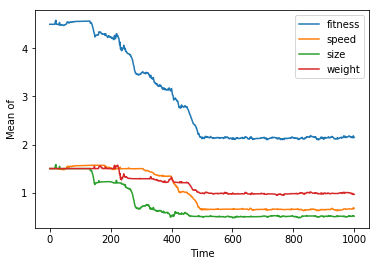

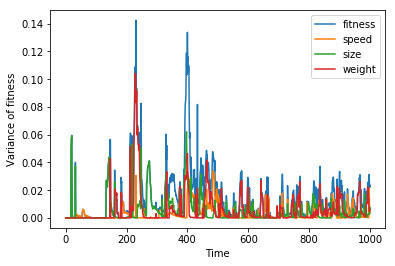

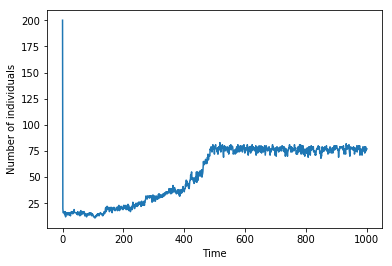

In [118]:
env5 = Environment3(n = 200, speed = 1.5, size = 1.5, weight = 1.5, energy = 150, mutation = 0.01, age = 10)
env5.run(days = 1000, nFood = 100)
env5.plot()

During 1000 days:

16543 individuals were born
16464 individuals died, 2046 of them by age
Mean of fitness: 2.1142918420515175
Mean of speed: 0.7021455649142023
Mean of size: 0.6247111477469028
Mean of weight: 0.7874351293904117


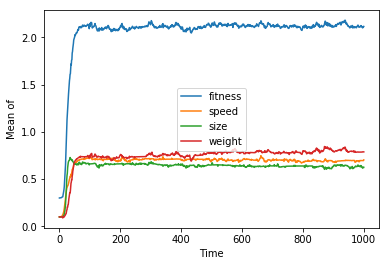

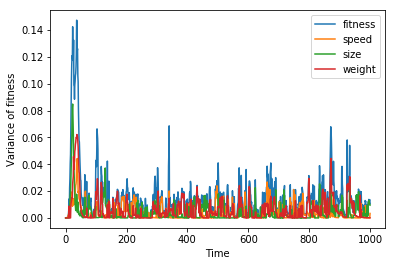

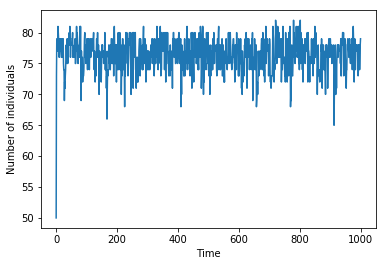

In [119]:
env6 = Environment3(n = 50, speed = 0.1, size = 0.1, weight = 0.1, energy = 150, mutation = 0.01, age = 10)
env6.run(days = 1000, nFood = 100)
env6.plot()